 
## End to end classification problem-Titanic

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt

In [2]:
!pip install pyarrow

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score

In [4]:
train=pd.read_parquet('train.parquet',engine='pyarrow')
test=pd.read_parquet('test.parquet',engine='pyarrow')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 199 to 225
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1047 non-null   int64  
 1   boat       1047 non-null   object 
 2   body       1047 non-null   int32  
 3   cabin      1047 non-null   object 
 4   embarked   1047 non-null   int64  
 5   fare       1047 non-null   float32
 6   home.dest  1047 non-null   object 
 7   name       1047 non-null   object 
 8   parch      1047 non-null   int32  
 9   pclass     1047 non-null   int64  
 10  sex        1047 non-null   int64  
 11  sibsp      1047 non-null   int32  
 12  survived   1047 non-null   int64  
 13  ticket     1047 non-null   object 
dtypes: float32(1), int32(3), int64(5), object(5)
memory usage: 106.3+ KB


In [6]:
test.shape

(262, 14)

Just for this part I will combine the test and the train to get know the varilables

In [7]:
data = pd.concat([train, test], axis=0, ignore_index=True)

In [8]:
data.shape

(1309, 14)

In [9]:
data.head()

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,-1,C,-1,Unknown,0,15.2458,Unknown,"Moubarek, Master. Halim Gonios ('William George')",1,2,0,1,1,2661
1,12,C,-1,Unknown,0,11.2417,Unknown,"Nicola-Yarred, Master. Elias",0,2,0,1,1,2651
2,18,Unknown,-1,Unknown,2,13.0000,"Kontiolahti, Finland / Detroit, MI","Hiltunen, Miss. Marta",1,1,1,1,0,250650
3,37,Unknown,-1,Unknown,2,9.5875,Unknown,"Laitinen, Miss. Kristina Sofia",0,2,1,0,0,4135
4,41,Unknown,-1,Unknown,2,39.6875,Unknown,"Panula, Mrs. Juha (Maria Emilia Ojala)",5,2,1,0,0,3101295


In the both 2  next cells  we can see the data information: data type,mean,std, min and max values and the observation number of each feature.
In this case, the observation number doesn't tell us anything since the missing value does not classified as NaaN(so that if we'll look at the count column in the describe tabel we'll see that there is 1309 values for each feature even though there's missing values).
In a similar way, there is features that are int type even though they dont have numeric meanings, for example: body,pclass,embarked 

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1309 non-null   int64  
 1   boat       1309 non-null   object 
 2   body       1309 non-null   int32  
 3   cabin      1309 non-null   object 
 4   embarked   1309 non-null   int64  
 5   fare       1309 non-null   float32
 6   home.dest  1309 non-null   object 
 7   name       1309 non-null   object 
 8   parch      1309 non-null   int32  
 9   pclass     1309 non-null   int64  
 10  sex        1309 non-null   int64  
 11  sibsp      1309 non-null   int32  
 12  survived   1309 non-null   int64  
 13  ticket     1309 non-null   object 
dtypes: float32(1), int32(3), int64(5), object(5)
memory usage: 122.8+ KB


In [11]:
data[['fare','age']].describe()

,fare,age
count,1309.000000,1309.000000
mean,33.269306,23.657754
std,51.747574,17.868332
min,-1.000000,-1.000000
25%,7.895800,7.000000
50%,14.454200,24.000000
75%,31.275000,35.000000
max,512.329224,80.000000


## Understanding the data

### Survived:

In [12]:
data['survived'].value_counts()

0    809
1    500
Name: survived, dtype: int64

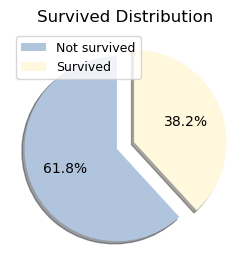

In [13]:
plt.figure(figsize=(5,3))
plt.title("Survived Distribution")
plt.pie(data['survived'].value_counts(),colors=['lightsteelblue','cornsilk'],autopct='%1.1f%%', explode=[0.1,0.1],shadow=True, startangle=90)
plt.legend( ['Not survived', 'Survived'],loc=2,prop={'size': 9})
plt.show()

### **Gender:**  
The Sex column that indicates gender get the values 0 or 1. we can inffer from the name columns which number fitts the genders.
Each name includes honorific: miss, master, MRS,MR. From looking at the names,we can see that MRS/miss get 1 and master/MR get 0.
Thuse: 1-Female, 0-male

In [14]:
data['sex'].value_counts()

0    843
1    466
Name: sex, dtype: int64

In [15]:
print("There is a",data['sex'].value_counts()[0],"male and",data['sex'].value_counts()[1],"female")

There is a 843 male and 466 female


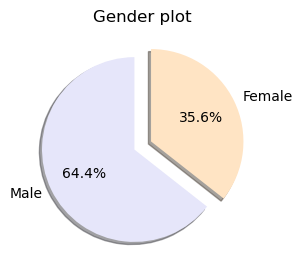

In [16]:
plt.figure(figsize=(5,3))
plt.title("Gender plot")
plt.pie(data['sex'].value_counts(), labels=['Male', 'Female'],colors=['lavender','bisque'],autopct='%1.1f%%', explode=[0.1,0.1],shadow=True, startangle=90)
plt.show()

### **Age:**  
Discrete variable

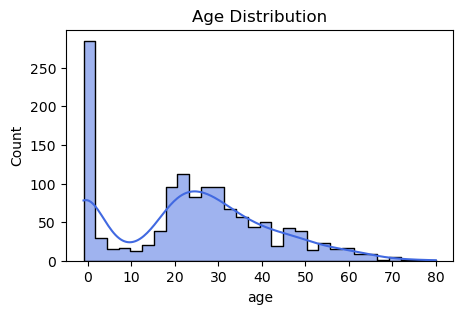

In [17]:
plt.figure(figsize=(5,3))
plt.title('Age Distribution')
age_stroke_plot=sns.histplot(data=data,x="age",kde=True,multiple='stack', bins=30,element="step",color='royalblue')

### **Embarked:**

Port of Embarkation.

In [18]:
print("The number of people who boarded at each port:",data['embarked'].value_counts())

The number of people who boarded at each port: 2    914
0    270
1    123
3      2
Name: embarked, dtype: int64


We can see that there is 4 uniqe value instade of 3.we will take care of it latter.

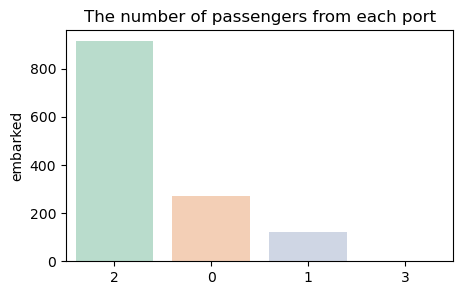

In [19]:
plt.figure(figsize=(5,3))
plt.title('The number of passengers from each port')
sns.barplot(x=['2','0','1','3'], y=data.embarked.value_counts(),palette='Pastel2')
plt.show()

### **Fare**

In [20]:
data.fare.describe()

count    1309.000000
mean       33.269306
std        51.747574
min        -1.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329224
Name: fare, dtype: float64

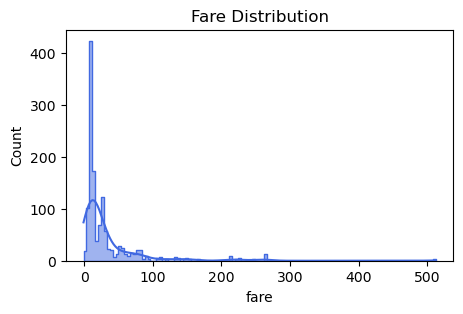

In [21]:
plt.figure(figsize=(5,3))
plt.title('Fare Distribution')
age_stroke_plot=sns.histplot(data=data,x="fare",kde=True,element="step",color='royalblue')

### **Fare by Pclass**

The instructions state that the departments are:
1 = 1st; 2 = 2nd; 3 = 3rd, but here the coding is 0-2.
We would like to verify which number indicates each department.  
From looking at each class in relation to the fare and the age of its passengers, we can see that as the cost of travel increases, the concentration of classes 1 and 2 decreases until it is non-existent. Therefore we conclude that 0 is the first class. We can also see that the dark points (2) are concentrated in the leftmost part of the graph where the travel prices are the lowest.Therefore we conclude that 2 is the 3rd class.  
Between the dark and light points there is a high concentration of the points indicating class 1.Therefore we conclude that 1 is the 2nd class.  
We can also see how the age range increases when it comes to the first class and ther is an higher concentration of young people and children in the third and second classes.
Most of the points indicating the first class are placed from the age of 20 and above.


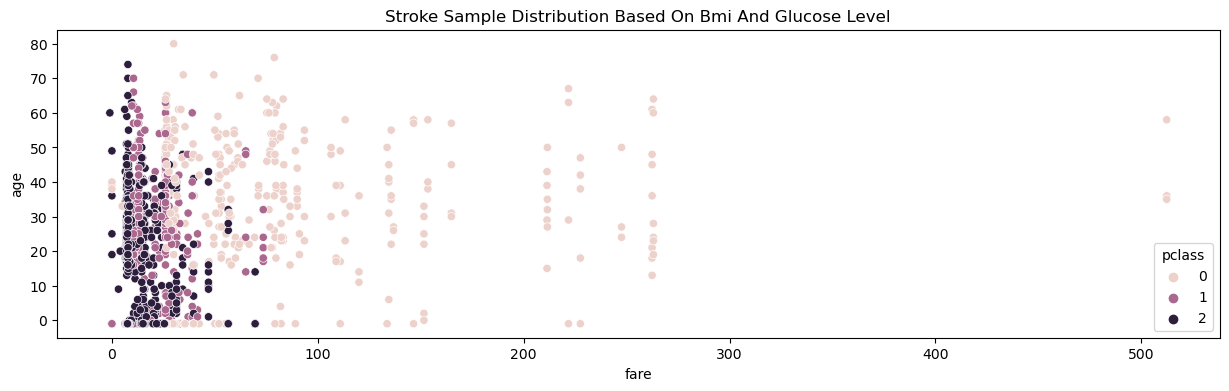

In [22]:
fig = plt.gcf()
fig.set_size_inches(15, 4)
plt.title('Stroke Sample Distribution Based On Bmi And Glucose Level')
sns.scatterplot(x=data['fare'],y=data['age'],hue=data['pclass'],palette=(sns.cubehelix_palette(3)))
plt.show()

### **Pclass**

In [23]:
print("The number of people at each class:"\
      ,data['pclass'].value_counts())

The number of people at each class: 2    709
0    323
1    277
Name: pclass, dtype: int64


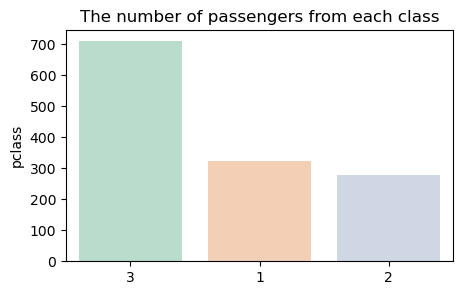

In [24]:
plt.figure(figsize=(5,3))
plt.title('The number of passengers from each class')
sns.barplot(x=['3','1','2'], y=data.pclass.value_counts(),palette='Pastel2')
plt.show()

### sibsp & parch:

sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard  
We can deduce from these data the number of persons in each family that boarded the ship.
We will add a column called "family" which is calculated by connecting *sibsp* and *parch*

In [25]:
data['family']=data['sibsp']+data['parch']+1
data.head(3)

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket,family
0,-1,C,-1,Unknown,0,15.2458,Unknown,"Moubarek, Master. Halim Gonios ('William George')",1,2,0,1,1,2661,3
1,12,C,-1,Unknown,0,11.2417,Unknown,"Nicola-Yarred, Master. Elias",0,2,0,1,1,2651,2
2,18,Unknown,-1,Unknown,2,13.0000,"Kontiolahti, Finland / Detroit, MI","Hiltunen, Miss. Marta",1,1,1,1,0,250650,3


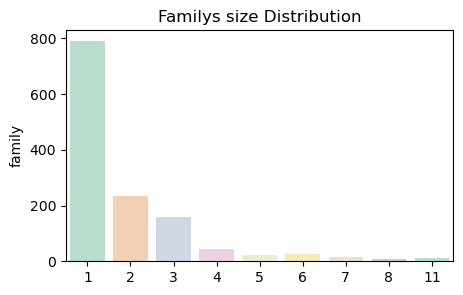

In [26]:
plt.figure(figsize=(5,3))
plt.title('Familys size Distribution')
sns.barplot(x=data.family.value_counts().index, y=data.family.value_counts(),palette='Pastel2')
plt.show()

## **Another interesting visualization and correlations**

maping the data

In [27]:
data['pclass'] = data['pclass'].map({0: '1st class', 1: '2nd class', 2: '3rd class'})
data['embarked'] =data['embarked'].map({0: '1', 1: '2', 2: '3'})
data["sex"] = data["sex"].map({0: 'Male', 1:'Female'})

In [28]:
#This function will be used for the following visualizations

In [29]:
def plot(df_toplot,title,leg,x_label,y_label,color):
    plotdf=df_toplot
    ax=plotdf.plot(kind='bar', stacked=True,colormap=color,figsize=(7, 3), label='12')
    plt.title(title)
    plt.legend(leg,fontsize='small',loc=1)
    plt.xlabel(x_label,fontsize='small')
    plt.xticks(rotation=0)
    plt.ylabel(y_label,fontsize='small')
    for bars, color in zip(ax.containers, '#6890F0'):
        labels = [f'{x:.1%}' for x in bars.datavalues]
        ax.bar_label(bars, labels=labels, label_type='center',fontsize=10,fontweight="bold")
    plt.show()

In [30]:
pd.crosstab(index=data['sex'],columns=data['survived'])

survived,0,1
sex,,
Female,127,339
Male,682,161


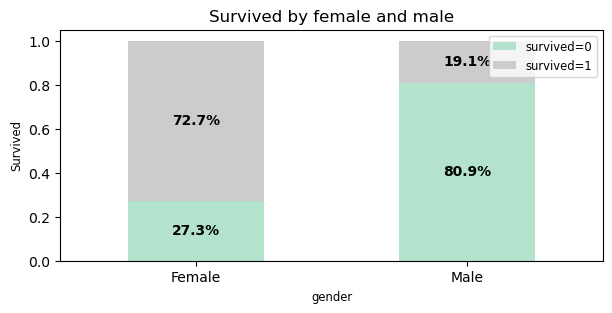

In [31]:
dfp=round(pd.crosstab(index=data['sex'],columns=data['survived'],normalize="index"),3)
plot(dfp,"Survived by female and male",['survived=0', 'survived=1'],"gender","Survived",color="Pastel2")

In [32]:
pd.crosstab(index=data['embarked'],columns=data['survived'])

survived,0,1
embarked,,
1,120,150
2,79,44
3,610,304


The highest percentage of survivors is from first class, followed by second and third

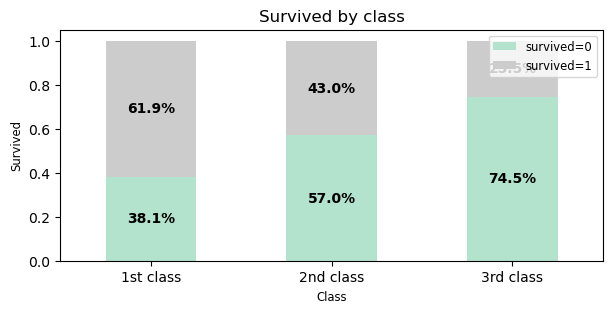

In [33]:
dfp=round(pd.crosstab(index=data['pclass'],columns=data['survived'],normalize="index"),3)
plot(dfp,"Survived by class",['survived=0', 'survived=1'],"Class","Survived",color="Pastel2")

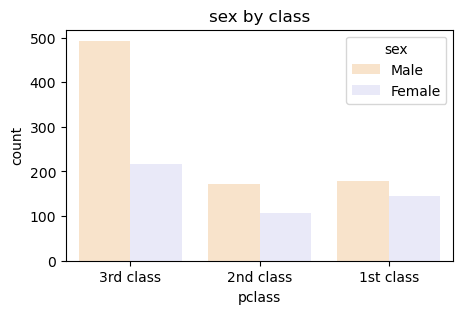

In [34]:
plt.figure(figsize=(5,3))
plt.title("sex by class")
sns.countplot(data=data, x='pclass', hue = 'sex',palette=['bisque','lavender'])
plt.show()

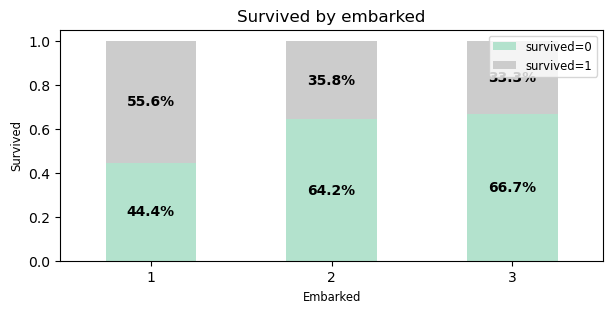

In [35]:
dfp=round(pd.crosstab(index=data['embarked'],columns=data['survived'],normalize="index"),3)
plot(dfp,"Survived by embarked",['survived=0', 'survived=1'],"Embarked","Survived",color="Pastel2")

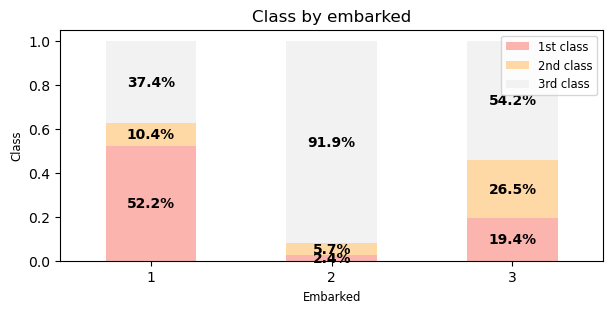

In [36]:
dfp=round(pd.crosstab(index=data['embarked'],columns=data['pclass'],normalize="index"),3)
plot(dfp,"Class by embarked",['1st class','2nd class','3rd class'],"Embarked","Class",color="Pastel1")

Most of the passengers who boarded at the first port are first class. But the relationship between the classes and the port alone does not explain the relationship between the port and the number of survivors, since we would expect that most of the passengers who boarded at port 2 belong to first and second class.  
As you can see in the graph, most of the passengers from Port 3 are from third class. 
Lets' check the average age in relation to each department and port

The smallest average age is in Port 2. This is in line with the fact that most of the passengers who boarded it are passengers from 3rd class.

<AxesSubplot:title={'center':'age'}, xlabel='embarked'>

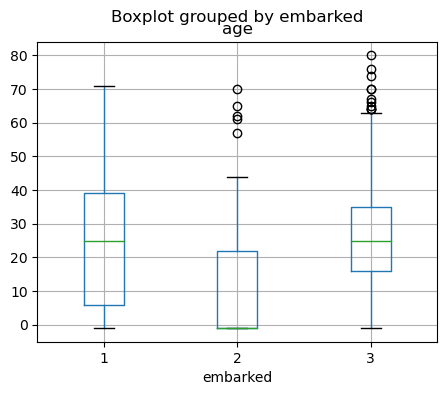

In [37]:
data.boxplot(column='age',by='embarked',figsize=(5,4))

<AxesSubplot:title={'center':'age'}, xlabel='pclass'>

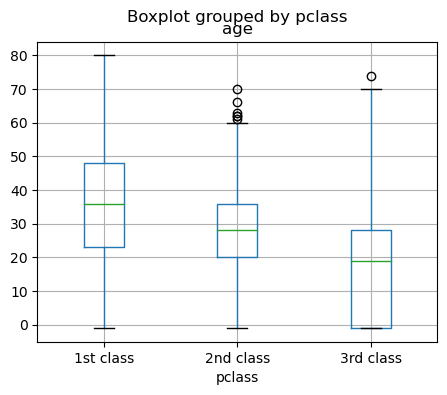

In [38]:
data.boxplot(column='age',by='pclass',figsize=(5,4))

In [39]:
pd.crosstab(index=data['embarked'],columns=data['pclass'])

pclass,1st class,2nd class,3rd class
embarked,,,
1,141,28,101
2,3,7,113
3,177,242,495


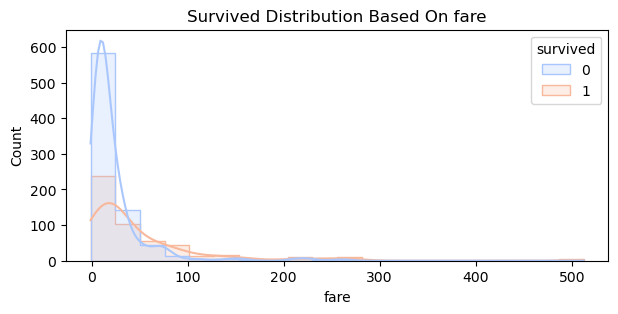

In [40]:
plt.figure(figsize=(7,3))
plt.title('Survived Distribution Based On fare')
age_stroke_plot=sns.histplot(data=data,x="fare",hue="survived",kde=True,element="step",palette='coolwarm',bins=20)

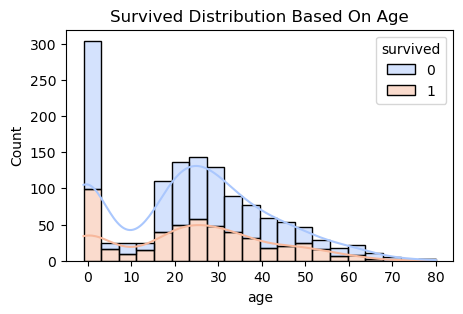

In [41]:
plt.figure(figsize=(5,3))
plt.title('Survived Distribution Based On Age')
age_stroke_plot=sns.histplot(data=data,x="age",hue="survived", multiple='stack', bins=20, kde=True, palette='coolwarm')

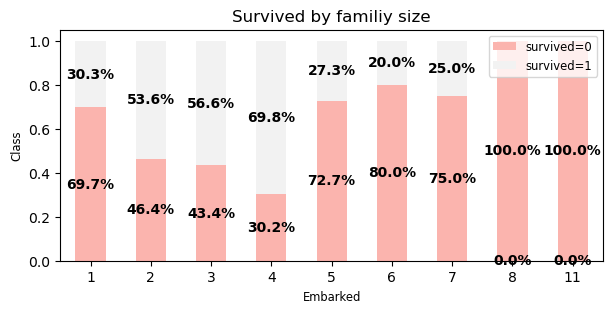

In [42]:
dfp=round(pd.crosstab(index=data['family'],columns=data['survived'],normalize="index"),3)
plot(dfp,"Survived by familiy size",['survived=0', 'survived=1'],"Embarked","Class",color="Pastel1")

**Boat & Body:**  
These variables depend on the target variable-*Survived*. If the passenger survived ther is a lifeboat and if not ther is a body number.Since these variables depend on the variable we want to predict, they cannot be used for prediction.this calld leakage.   **Cabine:**  
Indicates the cell number. Since we have information about the class in which the passenger traveled, we will not be able to derive any additional benefit from this variable. Therefore, as part of the data handling process, we will remove it.  
**Ticket & cabine:**  
Similarly, we have information about the cost of travel for each passenger and class(wich indicate flor too). Therefore we will also remove this variable  
**Home.dest:**  
Logically, a traveler's destination does not affect their ability to survive. we will remove this column too.


**missing data:**

Now we take a looke at the missing values in the  percentage of missing values in each variable:

In [43]:
data=data.replace({-1: np.nan, 'Unknown': np.nan})
missing_values = pd.DataFrame({'Null Values' : data.isna().sum(), 'Percentage Null Values' : round(data.isnull().sum()*100/len(data),3)})
missing_values = missing_values.sort_values('Percentage Null Values',ascending = False)
missing_values

,Null Values,Percentage Null Values
body,1188,90.756
cabin,1014,77.464
boat,823,62.872
home.dest,564,43.086
age,263,20.092
embarked,2,0.153
fare,1,0.076
name,0,0.000
parch,0,0.000
pclass,0,0.000


**visualizations Summary**  
It seems that the variables that particularly affect survival are: sex (women had a higher chance), class and age

## Featuer Engeenering

In this part of data prossesing, I refer to the following steps:  
1. remove leakge and unrelevant varilables
2. remove outlaiers
2. filling-in missing values
3. adding new features and converts categorical data into indicator variables(dummies)
4. looke at corrolations

**outliers**

In [44]:
def outliers(data):
    numerical_columns =['age','fare']
    for feature in numerical_columns:
        data[feature] = data[feature].clip(data[feature].quantile(0.10), data[feature].quantile(0.9)) #We will clip the values to the 1% and 99% quantile 
    return data 

In [45]:
train=outliers(train)

In [46]:
train.shape

(1047, 14)

In order to be able to handle the data properly, we will update the indexes to be in ascending order.

In [47]:
def new_index(data):
    new_index=np.arange(0,len(data))#new index array
    data=data.set_index(pd.Index(new_index))#seting the new index
    return data

In [48]:
train=new_index(train)

To be able handle missing values easily, we wi'll replace the -1 and Unknown  values by NaN.

In [49]:
def fill_with_NaN(data):
    data=data.replace({-1: np.nan, 'Unknown': np.nan})
    return data


In [50]:
train=fill_with_NaN(train)

In [51]:
def editing(data):
    #Removal of the unnecessary port
    arr=data['embarked'].value_counts()
    if len(np.sort(arr.index))>3:
        data = data[data.embarked != max(np.sort(arr.index))]
        data=data.reset_index(drop=True)
    
    #mapping
    data['embarked'] = data['embarked']+1
    data['pclass'] = data['pclass'].map({0: '1st class', 1: '2nd class', 2: '3rd class'})
    data["sex"] = data["sex"].map({0: 'Male', 1:'Female'})
    return data

In [52]:
train=editing(train)

In [53]:
train.embarked.value_counts()

3    740
1    207
2     98
Name: embarked, dtype: int64

In [54]:
train.head()

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,NaN,C,NaN,NaN,1,15.2458,NaN,"Moubarek, Master. Halim Gonios ('William George')",1,3rd class,Male,1,1,2661
1,12.0,C,NaN,NaN,1,11.2417,NaN,"Nicola-Yarred, Master. Elias",0,3rd class,Male,1,1,2651
2,18.0,NaN,NaN,NaN,3,13.0000,"Kontiolahti, Finland / Detroit, MI","Hiltunen, Miss. Marta",1,2nd class,Female,1,0,250650
3,37.0,NaN,NaN,NaN,3,9.5875,NaN,"Laitinen, Miss. Kristina Sofia",0,3rd class,Female,0,0,4135
4,41.0,NaN,NaN,NaN,3,39.6875,NaN,"Panula, Mrs. Juha (Maria Emilia Ojala)",5,3rd class,Female,0,0,3101295


Now,we'll drop the irrelevant columns add column that will contain the honorific: miss, master, MRS,MR. We will use this to complete missing data.

In [55]:
def col_adding_droping(df,col_to_drop):
    df=df.drop(col_to_drop, axis=1)
    df['honorific name'] =[str(df['name'][i]).split(',')[1].split('.')[0] for i in range(0,len(df))]
    df['Num_family members']=df['sibsp']+df['parch']+1
    df=df.reset_index(drop=True)
    return df

In [56]:
train=col_adding_droping(train,col_to_drop=['boat','body','home.dest','cabin','ticket'])

In [57]:
train.head()

,age,embarked,fare,name,parch,pclass,sex,sibsp,survived,honorific name,Num_family members
0,NaN,1,15.2458,"Moubarek, Master. Halim Gonios ('William George')",1,3rd class,Male,1,1,Master,3
1,12.0,1,11.2417,"Nicola-Yarred, Master. Elias",0,3rd class,Male,1,1,Master,2
2,18.0,3,13.0000,"Hiltunen, Miss. Marta",1,2nd class,Female,1,0,Miss,3
3,37.0,3,9.5875,"Laitinen, Miss. Kristina Sofia",0,3rd class,Female,0,0,Miss,1
4,41.0,3,39.6875,"Panula, Mrs. Juha (Maria Emilia Ojala)",5,3rd class,Female,0,0,Mrs,6


In [58]:
def handle_missing(df):
    df['fare']=df.groupby(['pclass','embarked'])[['fare']].apply(lambda x: x.fillna(x.mean()))
    if df.age.isnull().values.any() == True:
        df['fare'] = df['fare'].fillna(df['fare'].mean())
    df['age']=df.groupby(['embarked','pclass','honorific name'])[['age']].apply(lambda x: x.fillna(x.mean()))
    if df.age.isnull().values.any() == True:
        df['age'] = df['age'].fillna(df['age'].mean())
    df['embarked']=df['embarked'].replace({np.nan:df['pclass'].value_counts().idxmax()})
    df=df.reset_index(drop=True)
    return df   

In [59]:
train=handle_missing(train)

In [60]:
train.head()

,age,embarked,fare,name,parch,pclass,sex,sibsp,survived,honorific name,Num_family members
0,6.25,1,15.2458,"Moubarek, Master. Halim Gonios ('William George')",1,3rd class,Male,1,1,Master,3
1,12.00,1,11.2417,"Nicola-Yarred, Master. Elias",0,3rd class,Male,1,1,Master,2
2,18.00,3,13.0000,"Hiltunen, Miss. Marta",1,2nd class,Female,1,0,Miss,3
3,37.00,3,9.5875,"Laitinen, Miss. Kristina Sofia",0,3rd class,Female,0,0,Miss,1
4,41.00,3,39.6875,"Panula, Mrs. Juha (Maria Emilia Ojala)",5,3rd class,Female,0,0,Mrs,6


In [61]:
def dummies(data):
    #Num_family members
    group_names = ['s_f','m_f','b_f']
    bins = [1,4,5,11]
    data['family_size'] = pd.cut(data['Num_family members'], bins=bins, labels=group_names)
    #age groups
    group_names = ['babys-child','teen','20-50','50-80']
    bins = [0,10,19,50,80]
    data['Age_Group'] = pd.cut(data['age'], bins=bins, labels=group_names)
    #fare groups by quantails
    group_names = ['fare_q1','fare_q2']
    bins = [0,data['fare'].quantile(q=0.50),data['fare'].max()]
    data['fair_Q'] = pd.cut(data['fare'], bins=bins, labels=group_names)
    data=data.drop(['fare','name','age','parch','sibsp','Num_family members','honorific name'], axis=1)
    data=pd.get_dummies(data,columns=["Age_Group","embarked","fair_Q","pclass","sex","family_size"])
    return data

In [62]:
train=dummies(train)

In [63]:
train.head(3)

,survived,Age_Group_babys-child,Age_Group_teen,Age_Group_20-50,Age_Group_50-80,embarked_1,embarked_2,embarked_3,fair_Q_fare_q1,fair_Q_fare_q2,pclass_1st class,pclass_2nd class,pclass_3rd class,sex_Female,sex_Male,family_size_s_f,family_size_m_f,family_size_b_f
0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0
1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0
2,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0


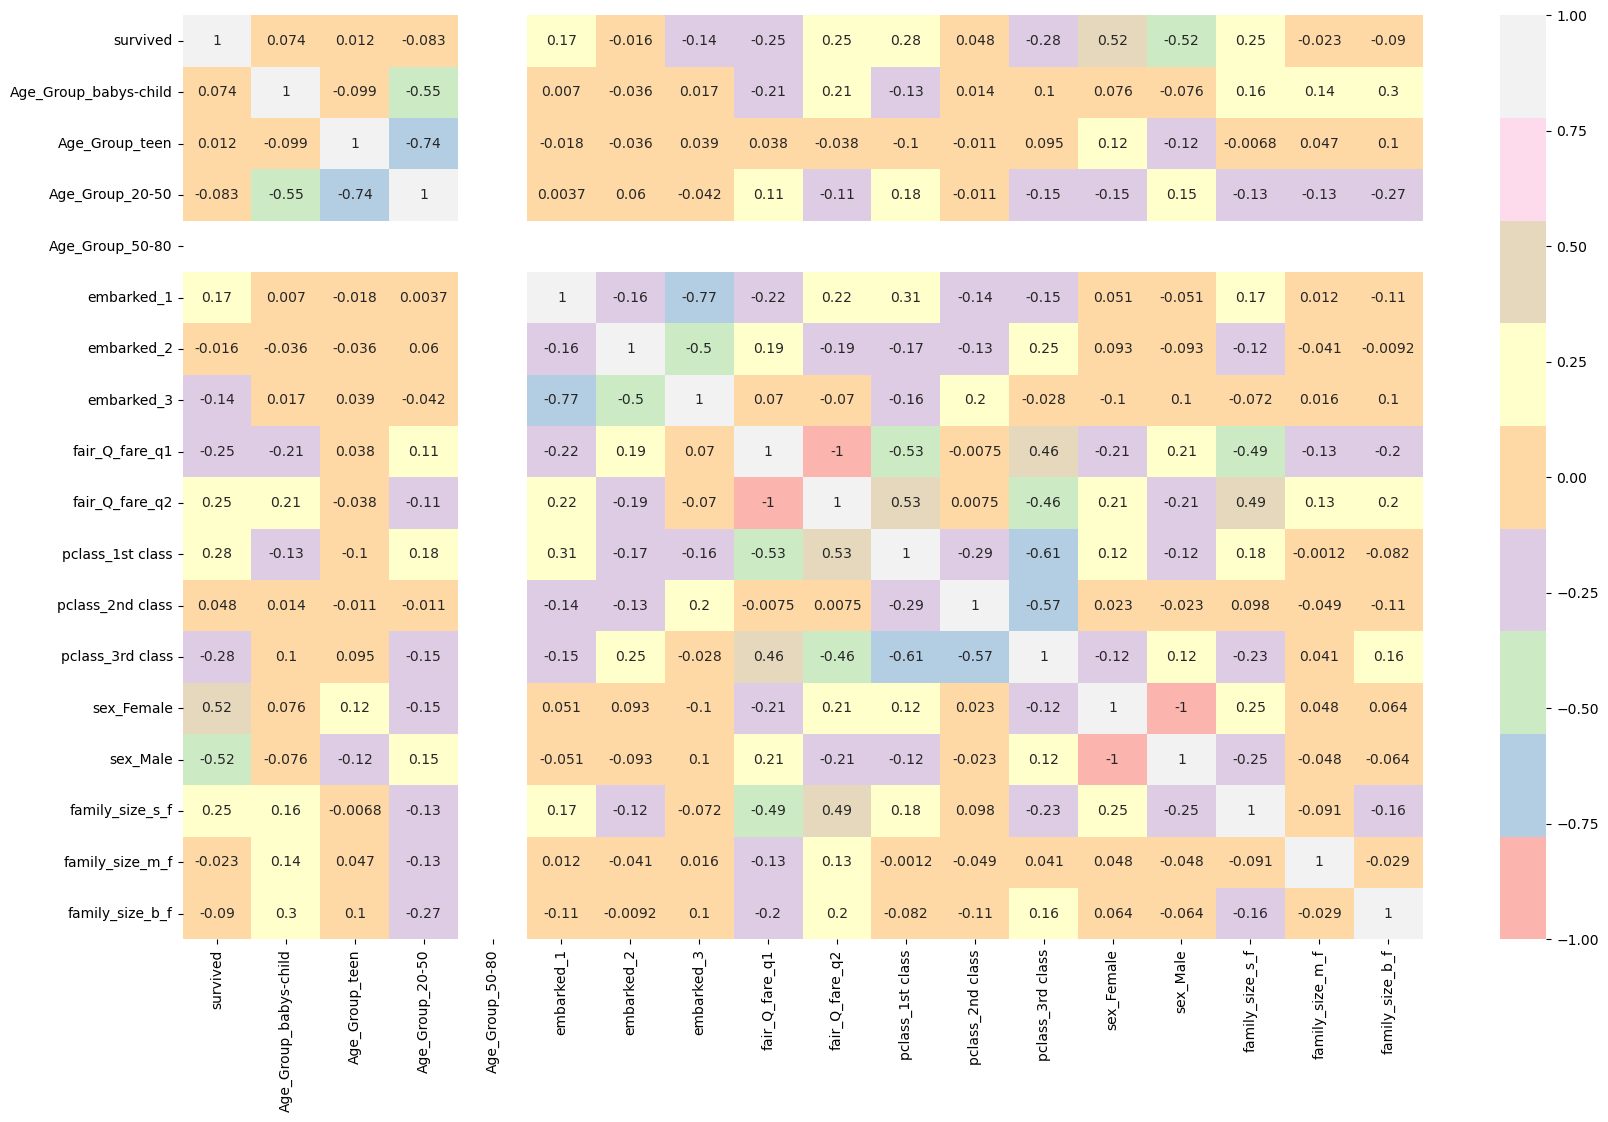

In [64]:
rho=train.corr()
plt.figure(figsize=(20,12))
sns.heatmap(rho,annot=True,cmap="Pastel1");

In [65]:
def pipe(dataset):
    dataset = dataset.pipe(outliers).pipe(new_index).pipe(fill_with_NaN).pipe(editing).pipe(col_adding_droping,col_to_drop=['boat','body','home.dest','cabin','ticket'])\
                     .pipe(handle_missing).pipe(dummies)
    return dataset

test=pipe(test)

In [66]:
test.head()

,survived,Age_Group_babys-child,Age_Group_teen,Age_Group_20-50,Age_Group_50-80,embarked_1,embarked_2,embarked_3,fair_Q_fare_q1,fair_Q_fare_q2,pclass_1st class,pclass_2nd class,pclass_3rd class,sex_Female,sex_Male,family_size_s_f,family_size_m_f,family_size_b_f
0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0
2,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1
4,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,0


In [67]:
train.shape

(1045, 18)

In [68]:
test.shape

(262, 18)

## models

In [69]:
test.shape

(262, 18)

In [70]:
train.shape

(1045, 18)

In [71]:
x=train.drop("survived", axis=1)
y=train["survived"]

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12)

In [73]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    cf_matrix = confusion_matrix(y_test, y_pred) 
    plt.figure(figsize=(3,3))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show() 

### Logistic regression

Accuracy score:  0.784688995215311
Precision Score : 0.7012987012987013
Recall Score : 0.7105263157894737
Cross validation score:  0.7953528399311531
Confusion matrix: 
 [[110  23]
 [ 22  54]]


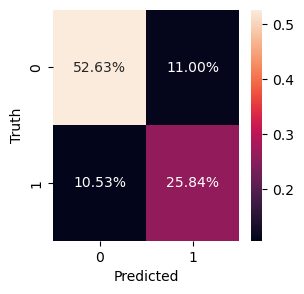

In [74]:
LogReg = LogisticRegression()  
LogReg.fit(x_train, y_train) 
y_pred_LogReg = LogReg.predict(x_test)

print("Accuracy score: ", accuracy_score(y_test, y_pred_LogReg))
print("Precision Score :",precision_score(y_test,y_pred_LogReg))
print("Recall Score :",recall_score(y_test,y_pred_LogReg))
print("Cross validation score: ", cross_val_score(LogReg, x_train, y_train, cv=10).mean())
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_LogReg))

plot_confusion_matrix(LogReg, x_test, y_test)

### Random Forest

Accuracy score:  0.8038277511961722
Precision Score : 0.7868852459016393
Recall Score : 0.631578947368421
Cross validation score:  0.8050344234079174
Confusion matrix: 
 [[120  13]
 [ 28  48]]


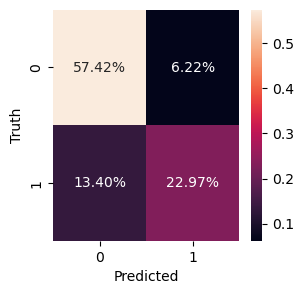

In [75]:
randomF = RandomForestClassifier(n_estimators=1000, max_depth=None, criterion="entropy", random_state=0)
randomF.fit(x_train, y_train) 
y_pred_RF = randomF.predict(x_test) 

print("Accuracy score: ", accuracy_score(y_test, y_pred_RF))
print("Precision Score :",precision_score(y_test, y_pred_RF))
print("Recall Score :",recall_score(y_test, y_pred_RF))
print("Cross validation score: ", cross_val_score(randomF, x_train, y_train, cv=10).mean())
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_RF))
plot_confusion_matrix(randomF, x_test, y_test)

**random forest with grid search**

In [76]:
# create the grid
n_estimators = [10, 100, 1000, 2000]
max_depth = [None, 5, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [77]:
rf = RandomForestClassifier(random_state=42)

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [78]:
y_pred_RF = grid_result.predict(x_test)

Accuracy score:  0.7942583732057417
Precision Score : 0.7704918032786885
Recall Score : 0.618421052631579
Cross validation score:  0.8050344234079174
Confusion matrix: 
 [[119  14]
 [ 29  47]]


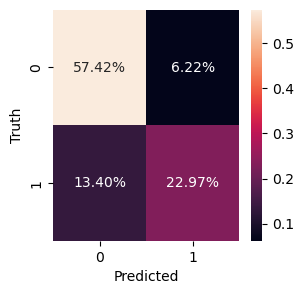

In [79]:
print("Accuracy score: ", accuracy_score(y_test, y_pred_RF))
print("Precision Score :",precision_score(y_test, y_pred_RF))
print("Recall Score :",recall_score(y_test, y_pred_RF))
print("Cross validation score: ", cross_val_score(randomF, x_train, y_train, cv=10).mean())
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_RF))
plot_confusion_matrix(randomF, x_test, y_test)

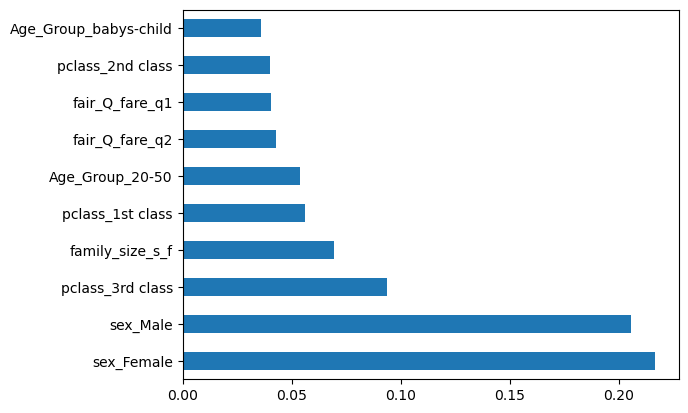

In [80]:
#the feature importance from the random forest model. 
feature_importance = pd.Series(randomF.feature_importances_, index=x_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()


### KNN (K-Nearest Neighbors)

C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Accuracy score:  0.7942583732057417
Precision Score : 0.8367346938775511
Recall Score : 0.5394736842105263
Cross validation score:  0.7942627653471026
Confusion matrix: 
 [[125   8]
 [ 35  41]]


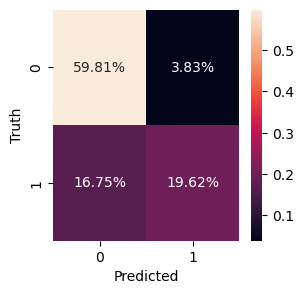

In [81]:
knn_m = KNeighborsClassifier(n_neighbors=10) 
knn_m.fit(x_train, y_train)
y_pred_knn = knn_m.predict(x_test)

print("Accuracy score: ", accuracy_score(y_test, y_pred_knn))
print("Precision Score :",precision_score(y_test, y_pred_knn))
print("Recall Score :",recall_score(y_test, y_pred_knn))
print("Cross validation score: ", cross_val_score(knn_m, x_train, y_train, cv=10).mean())
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_knn))

plot_confusion_matrix(knn_m, x_test, y_test)
#plt_classification_report(knn, x_test, y_test);

### SVM

Accuracy score:  0.7799043062200957
Precision Score : 0.6923076923076923
Recall Score : 0.7105263157894737
Cross validation score:  0.7941480206540448
Confusion matrix: 
 [[109  24]
 [ 22  54]]


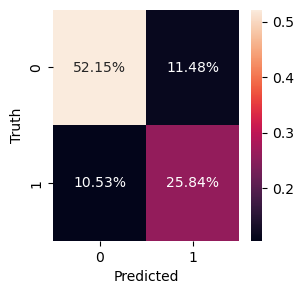

In [82]:
svm_m = SVC(C=1, kernel='linear')
svm_m.fit(x_train, y_train)
y_pred_svm = svm_m.predict(x_test)

print("Accuracy score: ", accuracy_score(y_test, y_pred_svm))
print("Precision Score :",precision_score(y_test, y_pred_svm))
print("Recall Score :",recall_score(y_test, y_pred_svm))
print("Cross validation score: ", cross_val_score(svm_m, x_train, y_train, cv=10).mean())
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svm))

plot_confusion_matrix(svm_m, x_test, y_test)

In [83]:
models_scores = {'Models': ['Logistic Regression', 'Random forest', 'KNN', 'SVM'],\
                'Accuracy': [accuracy_score(y_test, y_pred_LogReg),accuracy_score(y_test, y_pred_RF),\
                             accuracy_score(y_test, y_pred_knn),accuracy_score(y_test, y_pred_svm)]}
df = pd.DataFrame(models_scores)
df = df.sort_values(by='Accuracy', ascending=False) 

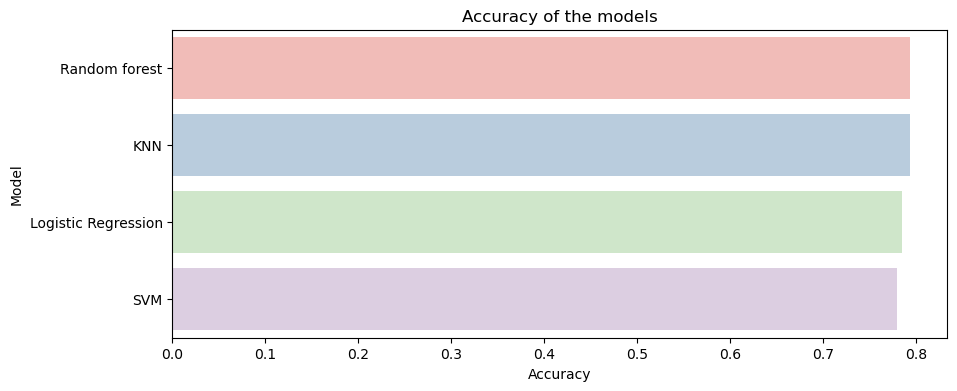

In [84]:
plt.figure(figsize=(10,4))

sns.barplot(x='Accuracy', y='Models', data=df,palette='Pastel1')
plt.title('Accuracy of the models')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

### Test

In [85]:
test_y = test['survived']
test_x=test.drop('survived', axis=1)

In [86]:
def score(test_y,pred_y):
    print("Accuracy score: ", accuracy_score(test_y, pred_y))
    print("Precision Score :",precision_score(test_y, pred_y))
    print("Recall Score :",recall_score(test_y, pred_y))
    print("Confusion matrix: \n", confusion_matrix(test_y, pred_y))

**random forest**

In [87]:
pred_y = randomF.predict(test_x)
score(test_y,pred_y)

Accuracy score:  0.8320610687022901
Precision Score : 0.8395061728395061
Recall Score : 0.6868686868686869
Confusion matrix: 
 [[150  13]
 [ 31  68]]


**Logistic regression**

In [88]:
y_pred_LogReg = LogReg.predict(test_x)
score(test_y,y_pred_LogReg)

Accuracy score:  0.8244274809160306
Precision Score : 0.7912087912087912
Recall Score : 0.7272727272727273
Confusion matrix: 
 [[144  19]
 [ 27  72]]


**KNN**

In [89]:
y_pred_knn = knn_m.predict(test_x)
score(test_y,y_pred_knn)

Accuracy score:  0.7900763358778626
Precision Score : 0.8666666666666667
Recall Score : 0.5252525252525253
Confusion matrix: 
 [[155   8]
 [ 47  52]]


C:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


**SVM**

In [90]:
y_pred_svm = svm_m.predict(test_x)
score(test_y,y_pred_svm)

Accuracy score:  0.8282442748091603
Precision Score : 0.7872340425531915
Recall Score : 0.7474747474747475
Confusion matrix: 
 [[143  20]
 [ 25  74]]


In [91]:
models_scores = {'Models': ['Logistic Regression', 'Random forest', 'KNN', 'SVM'],\
                'Accuracy': [accuracy_score(test_y, y_pred_LogReg),accuracy_score(test_y, pred_y),\
                             accuracy_score(test_y, y_pred_knn),accuracy_score(test_y, y_pred_svm)]}
df = pd.DataFrame(models_scores)
df = df.sort_values(by='Accuracy', ascending=False) 

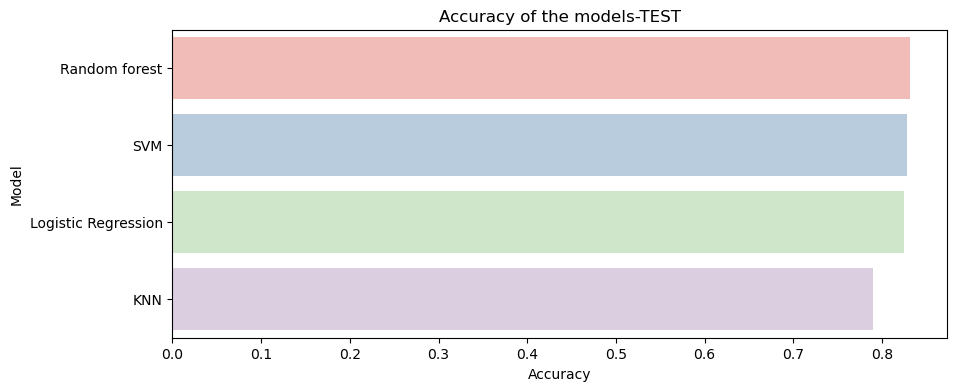

In [92]:
plt.figure(figsize=(10,4))

sns.barplot(x='Accuracy', y='Models', data=df,palette='Pastel1')
plt.title('Accuracy of the models-TEST')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

features that are good predictors for survival

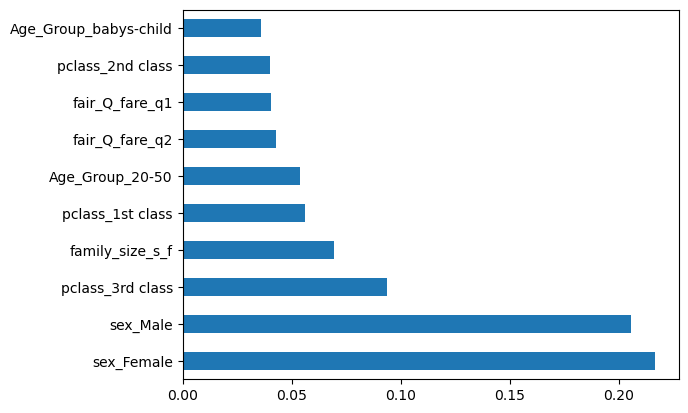

In [93]:
feature_importance = pd.Series(randomF.feature_importances_, index=test_x.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()